## Setup & read in data

In [1]:
from sklearn import preprocessing, model_selection

def preprocess(all_data):
#     Split the dataset into features and labels (clusters) - so we can normalise the features but not the labels
    all_X = all_data.iloc[:,2:len(all_data.columns)-1]
    all_y = all_data['cluster']
    
    # normalise the data so we have unit variance and mean 0 using built-in preprocessing method in sklearn
    scaler = preprocessing.StandardScaler()
    all_X= pd.DataFrame(scaler.fit_transform(all_X),columns=all_X.columns)
    
#     reset the indexes otherwise it was breaking
    all_X= all_X.reset_index()
    all_y = all_y.reset_index()
    all_X = all_X.drop(columns=['index'])
    all_y = all_y.drop(columns=['index'])
    
    #prepare data for training a model by splitting into training and testing data 
    return (all_X, all_y)

## Classification setup

In [2]:
#Set the class names
class_names = [4,2,0,5]

### setting up performance metrics calculations

In [3]:
from sklearn import metrics
#method to compute performance metrics 
def performance_metrics(y_true, y_pred):
    #create a confusion matrix from results 
    cnf_matrix  = metrics.confusion_matrix(y_true, y_pred, labels=class_names, sample_weight=None, normalize=None)
#     # average over all classes to find overall fp,fn,tp,tn
#     FP = np.sum(cnf_matrix, axis=0) - np.diag(cnf_matrix)
#     FN = np.sum(cnf_matrix, axis=1) - np.diag(cnf_matrix)
#     TP = np.diag(cnf_matrix)
#     TN = np.sum(cnf_matrix) - (FP + FN + TP)
        
    #find out if each predicted label is right 
    correct_labels = 0
    for i, true_label in enumerate(y_true):
        if (true_label == y_pred[i]):
            correct_labels += 1

    #calculate overall accuracy
#     acc = np.round(correct_labels/y_pred.shape[0],2)
        
    # tp rate is the same as recall 
#     recall = np.sum(TP)/(np.sum(TP)+np.sum(FN))
#     FP_rate = np.sum(FP)/(np.sum(FP)+np.sum(TN))  
#     precision = np.sum(TP)/(np.sum(TP)+np.sum(FP)) 
#     f_measure = (2*precision*recall)/(precision + recall) 

    metrics_dict = metrics.classification_report(y_true,y_pred,output_dict=True)
    avg_metrics = metrics_dict['macro avg']
#     print(metrics_dict.values())
    recall = avg_metrics['recall']
    precision = avg_metrics['precision']
    f_measure = avg_metrics['f1-score']
    acc = metrics_dict['accuracy']
    
    print(metrics.classification_report(y_true,y_pred))
    
    return (acc, recall, precision, f_measure,
            cnf_matrix,)

#      np.round(cnf_matrix/cnf_matrix.sum(axis=1),2)

In [4]:
import seaborn as sn

#method to plot the confusion matrix 
def plot_confusion_matrix(confusion_matrix, class_names):
    conf_matrix = pd.DataFrame(confusion_matrix, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure()
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

## k-fold cross validation

Here we use k-fold cross validation to evaluate the effectiveness of our models, where each 'fold' results in a slightly different train/test split, allowing us to see how the model beaves with different data. We can compute various metrics about the model performance, and from these results, we can choose the most effective classification model.

In [5]:
from sklearn import model_selection 
from sklearn import linear_model
from sklearn import ensemble

def cross_val(all_X, all_y, class_names, downsampling, upsampling, down_prop, up_prop, clf, printing):
    print('cross-validating...')
    k_val = 3
    #use 3 splits 
    k_fold = model_selection.KFold(n_splits=k_val)
    strat_k_fold = model_selection.StratifiedKFold(n_splits=k_val, shuffle=True)

    #create empty arrays to store the results from each fold
    #we can then average these to get the overall classifications and performance 
    accuracies = np.empty(k_val)
    tp_rates = np.empty(k_val)
    precisions = np.empty(k_val)
    f_measures = np.empty(k_val)

    count = 0

    #split training data into training and validation sets
    for train_indices, validation_indices in strat_k_fold.split(all_X, all_y):
    #     print(X_train.index)
        X_training = all_X.iloc[train_indices]
        y_training = all_y.iloc[train_indices]
        X_validate = all_X.iloc[validation_indices]
        y_validate = all_y.iloc[validation_indices]
        
        # upsample the training data in each fold, if upsample = true
        #with stratified k fold, better not to upsample, as it preserves percentage of samples for each class 
#         print('value counts: ', y_training.value_counts())

        if(downsampling):
#             print('downsampling...')
            X_training, y_training = downsample(X_training, y_training, class_names, down_prop)
            if (printing):
                print('value counts: ', y_training.value_counts())

        if (upsampling):
#             print('upsampling...')
            X_training, y_training = upsample(X_training, y_training, class_names, up_prop)
            if (printing):
                print('value counts:', y_training.value_counts())
            
        # fit classifier
        clf.fit(X_training, y_training.values.ravel())
        
        #predict 
        y_predicted = clf.predict(X_validate)
        y_true_val = y_validate.cluster
        
        #if we are using the decision tree classifier we may want to export the tree to look at it 
        from sklearn import tree

        export_tree = False
        if(export_tree):
            for tree_in_forest in clf.estimators_:
                if(export_tree):
                    tree.export_graphviz(tree_in_forest, out_file="rotated_tree_eg.dot",filled = True, 
                                         feature_names = X_training.columns, class_names=class_names,
                                         rotate = True)
        if (printing):
            print(np.unique(y_predicted, return_counts=True))

        #see how validation set performs 
        acc, recall, precision, f_measure, confusion_matrix = performance_metrics(y_true_val.values, y_predicted)

        if (printing):
            #print performance results for each fold
            print("accuracy: ", acc)
            print("true positive rate / recall: ", recall)
            print("precision: ", precision)
            print("f measure: ", f_measure)
            plot_confusion_matrix(confusion_matrix, class_names)
            print("----------")

        # store info for each fold 
        accuracies[count] = acc
        tp_rates[count] = recall
        precisions[count] = precision
        f_measures[count] = f_measure
        count+=1
        
        
    #average scores
    cv_acc = np.mean(accuracies)
    cv_tp = np.mean(tp_rates)
    cv_precision = np.mean(precisions)
    cv_f_measure = np.mean(f_measures)


    print("overall average performance:")
    print("accuracy: ", cv_acc)
    print("true positive rate/recall: ", cv_tp)
    print("precision: ", cv_precision)
    print("f measure: ", cv_f_measure)
    
    return X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure


Method to perform grid search to find the best parameters for the random forest classifier, uses cross-val


Had to implement this manually due to library constraints and difficulties with upsampling properly inside gridsearch

In [6]:
from sklearn import model_selection, pipeline, ensemble

def grid_search_rand_forest(data_X, data_y,class_names, downsampling, upsampling, down_prop, up_prop):

    best_f = 0.0
    
    # gridsearch for parameter optimisation
    param_grid = { 
        'n_estimators': [5, 10, 15, 20, 30, 40, 60, 80],
        'max_depth': [5, 10, 15, None],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': [2, 5, 10],
        'criterion' :['gini', 'entropy']}
    
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for max_features in param_grid['max_features']:
                for min_samples_split in param_grid['min_samples_split']:
                    for criterion in param_grid['criterion']:
                        clf = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                               min_samples_split=min_samples_split, criterion=criterion)

                        X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, f_measure = cross_val(data_X, data_y, class_names, downsampling, upsampling, down_prop, up_prop, clf, printing=True)

                        if(f_measure > best_f):
                            best_f = f_measure
                            best_clf = clf
    
    # Create grid search object
#     clf = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

#     best_clf = clf.fit(data_X, data_y.values.ravel())

#     gridsearch_results = pd.DataFrame(best_clf.cv_results_)

    #sort according to overall rank score to find best params
#     best_params_found = gridsearch_results.sort_values('rank_test_score').iloc[0]
    print(best_clf)
    
    return best_clf

## Rebalancing classes

### Downsampling

To address class imbalance by removing some examples in most numerous classes

In [7]:
def downsample(train_X, train_y, class_names, down_prop):
    
    train_data_and_labels = train_X.copy()
    train_data_and_labels['cluster'] = train_y
    
    #find the largest class and the number of samples in training
    value_counts = train_data_and_labels.cluster.value_counts()
    max_val = max(value_counts)

    most_numerous =  train_data_and_labels.cluster.value_counts().index[0]
    big_cluster = train_data_and_labels[train_data_and_labels['cluster']==most_numerous]
    new_train = train_data_and_labels[train_data_and_labels.cluster!=most_numerous]
    #remove more individuals in largest class if limited classes, as class imbalance is bigger here
    reduced_cluster = big_cluster.sample(replace=False, n=int(len(big_cluster)*down_prop), random_state=1)
    train_down = new_train.append(reduced_cluster)
    y_train_down = train_down['cluster']
    X_train_down = train_down.iloc[:,0:len(train_down.columns)-1]        
    
    return X_train_down, y_train_down

### Upsampling 

This improves the prediction accuracy for the classes containing fewer individuals.

In [8]:
#upsample the least numerous classes
def upsample(train_X, train_y, class_names, up_prop):
    
    train_data_and_labels = train_X.copy()
    train_data_and_labels['cluster'] = train_y

    #find the largest class and the number of samples in training
    value_counts = train_data_and_labels.cluster.value_counts()
    max_val = max(value_counts)
        
    #upsampling all the classes in training data 
    for cluster in class_names:
        cluster_vals = train_data_and_labels[train_data_and_labels.cluster==cluster]
        num_in_cluster = len(cluster_vals.index)
        num_extra_samples = int(up_prop*(max_val - num_in_cluster))
        new_samples = cluster_vals.sample(replace=True, n=num_extra_samples, random_state=1)
        train_data_and_labels = train_data_and_labels.append(new_samples)
            
#     print(train_data_and_labels.cluster.value_counts())
    
    X_train_up = train_data_and_labels.iloc[:,0:len(train_data_and_labels.columns)-1]
    y_train_up = train_data_and_labels['cluster']
    
    return X_train_up, y_train_up

## Two-axis clustering approach

We now classify using the two-step clustering approach. First we use the clusters found using chapter codes, and then we use subclusters based on discharge data to find nuanced subclusters inside these.

In [9]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   

In [10]:
#this is the data including imputed values for test results etc 
all_data = pd.read_csv('imputed_all_data.csv')
parse_dates=['admission_date_structured']
subclusters = pd.read_csv('subclusters.csv')
# labels = pd.read_csv('chapter_codes_clusters3.csv')
combined_clean = pd.read_csv('combined_clean.csv')

In [11]:
orig_data_and_labels_comorb = pd.merge(all_data, subclusters[['id','disch_4']],
                           how='right', on='id')

In [12]:
#remove comorbidities 
orig_data_and_labels = orig_data_and_labels_comorb.drop(columns=['morbidity_Diabetes','morbidity_COPD',
                                                                 'morbidity_Hypertension','morbidity_Heartdisease',
                                                                 'morbidity_Renaldisease','morbidity_Tumor',
                                                                 'morbidity_Metabolicdisorders',
                                                                 'morbidity_Respiratorydiseases'])

In [13]:
orig_data_and_labels

,Unnamed: 0,id,Height,Weight,smoking_structured,age,blood_sugar_d1_min,blood_sugar_d1_max,blood_sugar_d3_min,blood_sugar_d3_max,...,AlbumintoGlobulinRatio,Male,Consciousness,Temperature,Respiratoryrate,Redcelldistributionwidth,SystolicBP,DiastolicBP,Lymphocyte(%),disch_4
0,0,100251,155.00000,60.0,0,62.0,4.660000,4.660000,4.925083,5.956664,...,1.382490,False,1.0,36.6,20.0,12.1,134.500000,68.500000,23.384615,3
1,1,101019,151.00000,63.0,0,72.0,5.300000,5.300000,3.902008,4.507097,...,1.129046,False,1.0,36.3,23.0,13.6,135.000000,80.000000,32.424242,3
2,2,102696,169.00000,80.0,0,63.0,5.190000,5.190000,5.538094,7.640623,...,1.367413,True,1.0,36.6,19.0,13.4,129.000000,91.000000,32.266155,3
3,3,101588,161.00000,57.0,0,39.0,4.939551,4.895466,4.694930,4.862858,...,1.125873,False,1.0,36.6,22.0,12.5,122.000000,74.500000,25.101747,3
4,4,100358,164.75961,65.0,0,62.0,5.793085,6.349398,5.576803,5.064091,...,1.006937,True,1.0,37.5,24.0,11.9,122.500000,80.000000,15.538462,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2792,101460,172.00000,72.0,0,49.0,4.340000,4.340000,5.230405,3.933495,...,1.560000,True,0.0,36.8,24.0,12.2,100.326822,66.389026,32.307692,3
2793,2793,100047,172.00000,75.0,0,45.0,4.091314,7.067830,4.062333,4.329303,...,1.263107,True,1.0,36.8,22.0,11.4,101.593761,78.039515,18.589744,3
2794,2794,103038,174.00000,72.0,0,56.0,4.330000,4.330000,5.489082,5.853361,...,1.460000,True,1.0,36.5,26.0,13.1,124.000000,76.000000,37.792496,3
2795,2795,100889,164.75961,80.0,0,74.0,4.040000,4.040000,4.339569,4.426759,...,1.150000,True,1.0,36.5,26.0,12.5,139.500000,100.500000,14.313725,3


### Predicting based on chapter codes clusters

In [14]:
orig_data_and_labels = orig_data_and_labels.rename(columns={'disch_4':'cluster'})
orig_data_and_labels.cluster.value_counts()

3    2126
0     285
2     210
1     176
Name: cluster, dtype: int64

Remove the largest cluster - this is the non-severe cluster 

In [15]:
num_to_remove = 1
# Remove the largest n clusters to focus on interesting ones 

value_counts = orig_data_and_labels.cluster.value_counts()
value_counts_list = value_counts.index.to_list()
interesting_clusters = value_counts_list[num_to_remove:len(value_counts)]

data_and_labels = orig_data_and_labels.loc[orig_data_and_labels['cluster'].isin(interesting_clusters)]

In [16]:
data_and_labels.cluster.value_counts()

0    285
2    210
1    176
Name: cluster, dtype: int64

In [17]:
chapters_all_X, chapters_all_y = preprocess(data_and_labels)

In [18]:
#Set the class names
class_names = [0,2,1]

#need to do gridsearch with new rebalanced samples 
# clf = grid_search_rand_forest(chapters_all_X, chapters_all_y, class_names, downsampling=True, upsampling=True, down_prop=1, up_prop=0.8)

#4 clusters
clf = ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=30)
#3 clusters
# clf = ensemble.RandomForestClassifier(n_estimators=80, max_depth=None, max_features='sqrt', 
#                                       min_samples_split=5, criterion='gini')

In [19]:
# class_names = orig_data_and_labels['cluster'].unique()
X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure = cross_val(chapters_all_X, chapters_all_y, class_names, downsampling = False, upsampling=True, down_prop=1, up_prop=0.8, clf=clf, printing=False)

cross-validating...
              precision    recall  f1-score   support

           0       0.50      0.56      0.52        95
           1       0.37      0.27      0.31        59
           2       0.49      0.51      0.50        70

    accuracy                           0.47       224
   macro avg       0.45      0.45      0.45       224
weighted avg       0.46      0.47      0.46       224

              precision    recall  f1-score   support

           0       0.43      0.47      0.45        95
           1       0.38      0.31      0.34        59
           2       0.36      0.37      0.37        70

    accuracy                           0.40       224
   macro avg       0.39      0.38      0.38       224
weighted avg       0.40      0.40      0.39       224

              precision    recall  f1-score   support

           0       0.48      0.55      0.51        95
           1       0.31      0.24      0.27        58
           2       0.43      0.43      0.43        70



### Classification of stage 2 clusters

In [20]:
# #this is the data including imputed values for test results etc 
all_data = pd.read_csv('imputed_all_data.csv')
parse_dates=['admission_date_structured']
# labels = pd.read_csv('chapter_codes_clusters3.csv')
combined_clean = pd.read_csv('combined_clean.csv')

In [21]:
subclusters = subclusters.rename(columns={'disch_4_sub_clusters':'cluster'})

In [22]:
subclusters

,Unnamed: 0,id,disch_3,disch_3_sub_clusters,disch_4,cluster
0,0,100251,1,1b,3,3a
1,1,101019,1,1d,3,3b
2,2,102696,1,1d,3,3b
3,3,101588,1,1d,3,3b
4,4,100358,1,1b,3,3a
...,...,...,...,...,...,...
2792,2792,101460,1,1d,3,3b
2793,2793,100047,1,1d,3,3b
2794,2794,103038,1,1b,3,3a
2795,2795,100889,1,1d,3,3b


In [23]:
orig_data_and_labels = pd.merge(all_data, subclusters[['id','cluster']],
                           how='right', on='id')
# orig_data_and_labels = pd.merge(all_data, sublabels_0,
#                            how='right', on='id')

In [24]:
#remove comorbidities 
orig_data_and_labels = orig_data_and_labels.drop(columns=['morbidity_Diabetes','morbidity_COPD',
                                                                 'morbidity_Hypertension','morbidity_Heartdisease',
                                                                 'morbidity_Renaldisease','morbidity_Tumor',
                                                                 'morbidity_Metabolicdisorders',
                                                                 'morbidity_Respiratorydiseases'])

In [25]:
orig_data_and_labels

,Unnamed: 0,id,Height,Weight,smoking_structured,age,blood_sugar_d1_min,blood_sugar_d1_max,blood_sugar_d3_min,blood_sugar_d3_max,...,AlbumintoGlobulinRatio,Male,Consciousness,Temperature,Respiratoryrate,Redcelldistributionwidth,SystolicBP,DiastolicBP,Lymphocyte(%),cluster
0,0,100251,155.00000,60.0,0,62.0,4.660000,4.660000,4.925083,5.956664,...,1.382490,False,1.0,36.6,20.0,12.1,134.500000,68.500000,23.384615,3a
1,1,101019,151.00000,63.0,0,72.0,5.300000,5.300000,3.902008,4.507097,...,1.129046,False,1.0,36.3,23.0,13.6,135.000000,80.000000,32.424242,3b
2,2,102696,169.00000,80.0,0,63.0,5.190000,5.190000,5.538094,7.640623,...,1.367413,True,1.0,36.6,19.0,13.4,129.000000,91.000000,32.266155,3b
3,3,101588,161.00000,57.0,0,39.0,4.939551,4.895466,4.694930,4.862858,...,1.125873,False,1.0,36.6,22.0,12.5,122.000000,74.500000,25.101747,3b
4,4,100358,164.75961,65.0,0,62.0,5.793085,6.349398,5.576803,5.064091,...,1.006937,True,1.0,37.5,24.0,11.9,122.500000,80.000000,15.538462,3a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2792,101460,172.00000,72.0,0,49.0,4.340000,4.340000,5.230405,3.933495,...,1.560000,True,0.0,36.8,24.0,12.2,100.326822,66.389026,32.307692,3b
2793,2793,100047,172.00000,75.0,0,45.0,4.091314,7.067830,4.062333,4.329303,...,1.263107,True,1.0,36.8,22.0,11.4,101.593761,78.039515,18.589744,3b
2794,2794,103038,174.00000,72.0,0,56.0,4.330000,4.330000,5.489082,5.853361,...,1.460000,True,1.0,36.5,26.0,13.1,124.000000,76.000000,37.792496,3a
2795,2795,100889,164.75961,80.0,0,74.0,4.040000,4.040000,4.339569,4.426759,...,1.150000,True,1.0,36.5,26.0,12.5,139.500000,100.500000,14.313725,3b


In [26]:
orig_data_and_labels.cluster.value_counts()

3b    1281
3a     845
0a     150
1b     131
2b     120
0c     113
2a      90
1a      45
0b      22
Name: cluster, dtype: int64

In [27]:
num_to_remove = 2
# Remove the largest n clusters to focus on interesting ones 

value_counts = orig_data_and_labels.cluster.value_counts()
value_counts_list = value_counts.index.to_list()
interesting_clusters = value_counts_list[num_to_remove:len(value_counts)]

data_and_labels = orig_data_and_labels.loc[orig_data_and_labels['cluster'].isin(interesting_clusters)]

In [28]:
data_and_labels.cluster.value_counts()

0a    150
1b    131
2b    120
0c    113
2a     90
1a     45
0b     22
Name: cluster, dtype: int64

create new dataframe for each cluster, so we have separate classification problems 

0b/1a is most severe

In [29]:
c0a = data_and_labels[data_and_labels.cluster == '0a']
c0b = data_and_labels[data_and_labels.cluster == '0b']
c0c = data_and_labels[data_and_labels.cluster == '0c']
c0 = pd.concat([c0a,c0b]).drop(columns={'Unnamed: 0'})
c0 = pd.concat([c0,c0c]).drop(columns={'Unnamed: 0'})

c1a = data_and_labels[data_and_labels.cluster == '1a']
c1b = data_and_labels[data_and_labels.cluster == '1b']
c1 = pd.concat([c1a,c1b]).drop(columns={'Unnamed: 0'})

c2a = data_and_labels[data_and_labels.cluster == '2a']
c2b = data_and_labels[data_and_labels.cluster == '2b']
c2 = pd.concat([c2a,c2b]).drop(columns={'Unnamed: 0'})

cSevere = pd.concat([c0b,c1a]).drop(columns={'Unnamed: 0'})

In [30]:
subchapters_all_X0, subchapters_all_y0 = preprocess(c0)
subchapters_all_X1, subchapters_all_y1 = preprocess(c1)
subchapters_all_X2, subchapters_all_y2 = preprocess(c2)
subchapters_all_XSevere, subchapters_all_ySevere = preprocess(cSevere)

hyperparameters 

In [31]:
# class_names=subchapters_all_y0.cluster.unique()
# clf0 = grid_search_rand_forest(subchapters_all_X0, subchapters_all_y0,class_names, downsampling=False, upsampling=True, down_prop=1, up_prop=0.8)
# clf0 = ensemble.RandomForestClassifier(max_features='sqrt', min_samples_split=10,
#                        n_estimators=20)

# class_names=subchapters_all_y1.cluster.unique()
# clf1 = grid_search_rand_forest(subchapters_all_X1, subchapters_all_y1,class_names, downsampling=False, upsampling=True, down_prop=1, up_prop=0.8)
# clf1 = ensemble.RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
#                        n_estimators=20)

# class_names=subchapters_all_y2.cluster.unique()
# clf2 = grid_search_rand_forest(subchapters_all_X2, subchapters_all_y2,class_names, downsampling=False, upsampling=True, down_prop=1, up_prop=0.8)
# clf2 = ensemble.RandomForestClassifier(max_features='log2', n_estimators=15)

class_names=subchapters_all_ySevere.cluster.unique()
# clfSevere = grid_search_rand_forest(subchapters_all_XSevere, subchapters_all_ySevere,class_names, downsampling=False, upsampling=True, down_prop=1, up_prop=0.8)
clfSevere = ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=5, n_estimators=5)

### Prediction

cross-validating...
value counts:  1a    30
0b    14
Name: cluster, dtype: int64
value counts: 1a    30
0b    26
Name: cluster, dtype: int64
(array(['0b', '1a'], dtype=object), array([10, 13]))
              precision    recall  f1-score   support

          0b       0.30      0.38      0.33         8
          1a       0.62      0.53      0.57        15

    accuracy                           0.48        23
   macro avg       0.46      0.45      0.45        23
weighted avg       0.51      0.48      0.49        23

accuracy:  0.4782608695652174
true positive rate / recall:  0.45416666666666666
precision:  0.45769230769230773
f measure:  0.4523809523809524


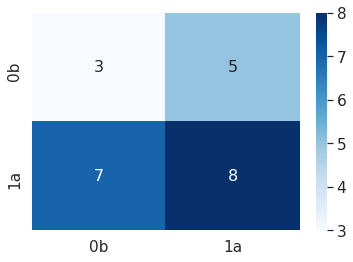

----------
value counts:  1a    30
0b    15
Name: cluster, dtype: int64
value counts: 1a    30
0b    27
Name: cluster, dtype: int64
(array(['0b', '1a'], dtype=object), array([ 8, 14]))
              precision    recall  f1-score   support

          0b       0.38      0.43      0.40         7
          1a       0.71      0.67      0.69        15

    accuracy                           0.59        22
   macro avg       0.54      0.55      0.54        22
weighted avg       0.61      0.59      0.60        22

accuracy:  0.5909090909090909
true positive rate / recall:  0.5476190476190476
precision:  0.5446428571428572
f measure:  0.5448275862068965


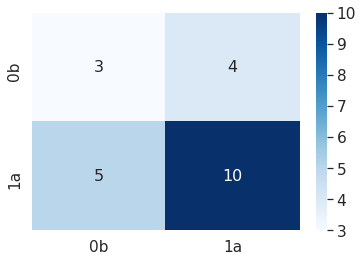

----------
value counts:  1a    30
0b    15
Name: cluster, dtype: int64
value counts: 1a    30
0b    27
Name: cluster, dtype: int64
(array(['0b', '1a'], dtype=object), array([10, 12]))
              precision    recall  f1-score   support

          0b       0.30      0.43      0.35         7
          1a       0.67      0.53      0.59        15

    accuracy                           0.50        22
   macro avg       0.48      0.48      0.47        22
weighted avg       0.55      0.50      0.52        22

accuracy:  0.5
true positive rate / recall:  0.4809523809523809
precision:  0.4833333333333333
f measure:  0.4727668845315904


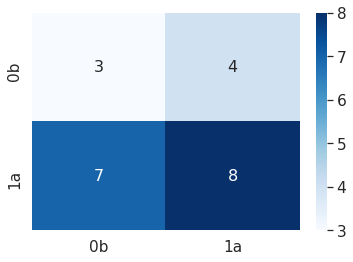

----------
overall average performance:
accuracy:  0.5230566534914362
true positive rate/recall:  0.4942460317460317
precision:  0.4952228327228328
f measure:  0.48999180770647977


In [33]:
# class_names = subchapters_all_y0['cluster'].unique()
# X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure = cross_val(subchapters_all_X0, subchapters_all_y0, class_names, 
#                                                            downsampling = True, upsampling=True,
#                                                            down_prop = 1, up_prop = 0.8, clf=clf0, printing=False)

# class_names = subchapters_all_y1['cluster'].unique()
# X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure = cross_val(subchapters_all_X1, subchapters_all_y1, class_names, 
#                                                            downsampling = True, upsampling=True,
#                                                            down_prop = 1, up_prop = 0.8, clf=clf1, printing=False)

# class_names = subchapters_all_y2['cluster'].unique()
# X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure = cross_val(subchapters_all_X2, subchapters_all_y2, class_names, 
#                                                            downsampling = True, upsampling=True,
#                                                            down_prop = 1, up_prop = 0.8, clf=clf1, printing=False)

class_names = subchapters_all_ySevere['cluster'].unique()
X_training, y_training, X_validate, y_validate, y_predicted, y_true_val, cv_f_measure = cross_val(subchapters_all_XSevere, subchapters_all_ySevere, class_names, 
                                                           downsampling = True, upsampling=True,
                                                           down_prop = 1, up_prop = 0.8, clf=clfSevere, printing=True)